# Effects of user characterestics on the Duration of the Trip

## Investigation Overview

> In this investigation, I wanted to look at the features of the trip that may predict its duration. I mainly focused on the age, type and gender of the users.

## Dataset Overview

> This data set includes information about individual rides made in a bike-sharing system covering the greater San Francisco Bay area. There are 174,952 trips in the dataset with information about when and where the trip started and ended, the duration of each trip, and some information about the users (type, gender, birth year).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sb
import datetime as dt
from scipy.stats import norm

%matplotlib inline

In [2]:
gobike=pd.read_csv('201902-fordgobike-tripdata.csv')
gobike.head()

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
0,52185,2019-02-28 17:32:10.1450,2019-03-01 08:01:55.9750,21.0,Montgomery St BART Station (Market St at 2nd St),37.789625,-122.400811,13.0,Commercial St at Montgomery St,37.794231,-122.402923,4902,Customer,1984.0,Male,No
1,42521,2019-02-28 18:53:21.7890,2019-03-01 06:42:03.0560,23.0,The Embarcadero at Steuart St,37.791464,-122.391034,81.0,Berry St at 4th St,37.775880,-122.393170,2535,Customer,NaN,NaN,No
2,61854,2019-02-28 12:13:13.2180,2019-03-01 05:24:08.1460,86.0,Market St at Dolores St,37.769305,-122.426826,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,5905,Customer,1972.0,Male,No
3,36490,2019-02-28 17:54:26.0100,2019-03-01 04:02:36.8420,375.0,Grove St at Masonic Ave,37.774836,-122.446546,70.0,Central Ave at Fell St,37.773311,-122.444293,6638,Subscriber,1989.0,Other,No
4,1585,2019-02-28 23:54:18.5490,2019-03-01 00:20:44.0740,7.0,Frank H Ogawa Plaza,37.804562,-122.271738,222.0,10th Ave at E 15th St,37.792714,-122.248780,4898,Subscriber,1974.0,Male,Yes


> First, I'm going to look at the general features of the dataset to remove any null values and duplicates, convert some columns to more appropriate types, remove any unrequires columns and add new columns that I'm going to use.

In [3]:
gobike.shape

(183412, 16)

In [4]:
gobike.isnull().sum().sum()

17318

In [5]:
gobike.dropna(inplace=True)
gobike.isnull().sum().sum()

0

In [6]:
gobike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             174952 non-null  int64  
 1   start_time               174952 non-null  object 
 2   end_time                 174952 non-null  object 
 3   start_station_id         174952 non-null  float64
 4   start_station_name       174952 non-null  object 
 5   start_station_latitude   174952 non-null  float64
 6   start_station_longitude  174952 non-null  float64
 7   end_station_id           174952 non-null  float64
 8   end_station_name         174952 non-null  object 
 9   end_station_latitude     174952 non-null  float64
 10  end_station_longitude    174952 non-null  float64
 11  bike_id                  174952 non-null  int64  
 12  user_type                174952 non-null  object 
 13  member_birth_year        174952 non-null  float64
 14  memb

In [7]:
gobike.duplicated().sum()

0

In [8]:
gobike['start_time']=pd.to_datetime(gobike['start_time'])
gobike['end_time']=pd.to_datetime(gobike['end_time'])

In [9]:
gobike['start_time'].dt.year.unique()

array([2019], dtype=int64)

In [10]:
gobike['age']=(2019-gobike['member_birth_year']).astype(int)

In [11]:
gobike.drop(['start_station_id','end_station_id','bike_id','member_birth_year','start_station_longitude','start_station_latitude','end_station_longitude','end_station_latitude'],axis=1,inplace=True)

In [12]:
gobike['start_hour'] = gobike['start_time'].dt.hour

In [13]:
gobike.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 10 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_name       174952 non-null  object        
 4   end_station_name         174952 non-null  object        
 5   user_type                174952 non-null  object        
 6   member_gender            174952 non-null  object        
 7   bike_share_for_all_trip  174952 non-null  object        
 8   age                      174952 non-null  int32         
 9   start_hour               174952 non-null  int64         
dtypes: datetime64[ns](2), int32(1), int64(2), object(5)
memory usage: 14.0+ MB


In [14]:
gobike.describe()

,duration_sec,age,start_hour
count,174952.000000,174952.000000,174952.000000
mean,704.002744,34.196865,13.456165
std,1642.204905,10.118731,4.734282
min,61.000000,18.000000,0.000000
25%,323.000000,27.000000,9.000000
50%,510.000000,32.000000,14.000000
75%,789.000000,39.000000,17.000000
max,84548.000000,141.000000,23.000000


In [15]:
print(gobike['user_type'].unique())
print(gobike['member_gender'].unique())
print(gobike['bike_share_for_all_trip'].unique())

['Customer' 'Subscriber']
['Male' 'Other' 'Female']
['No' 'Yes']


### What is the structure of your dataset?

> There are 174,952 trips in the dataset with information about when and where the trip started and ended, the duration of each trip, and some information about the user (type, gender, birth year). The dataset contains 10 columns; 3 numeric(duration_sec, age, start_hour), 2 datetime (start_time, end_time), 3 nominal (start_station_name, end_station_name, member_gender) and 2 binary (user_type and bike_share_for_all_trip).

### What is/are the main feature(s) of interest in your dataset?

> I'm most interested in understanding the duration of the trip.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I expect that the duration of the trip is mostly affected by the age of the user and also by where the trip started and ended, so I think that the most important features for my investigation are 8 (duration_sec, age start_hour, start_station_name, end_station_name, user_type, member_gender and bike_share_for_all_trip).

## Univariate Exploration

> In this section, I'm going to investigate distributions of individual variables, take a deeper look to clean things up and prepare  to look at relationships between variables.

> First, I look at the most common start and end stations.

In [16]:
start_counts = gobike['start_station_name'].value_counts().reset_index(name='number_of_trips')[:20]
start_order=start_counts['index']

In [17]:
start_sub=gobike.loc[gobike['start_station_name'].isin(start_counts["index"])]

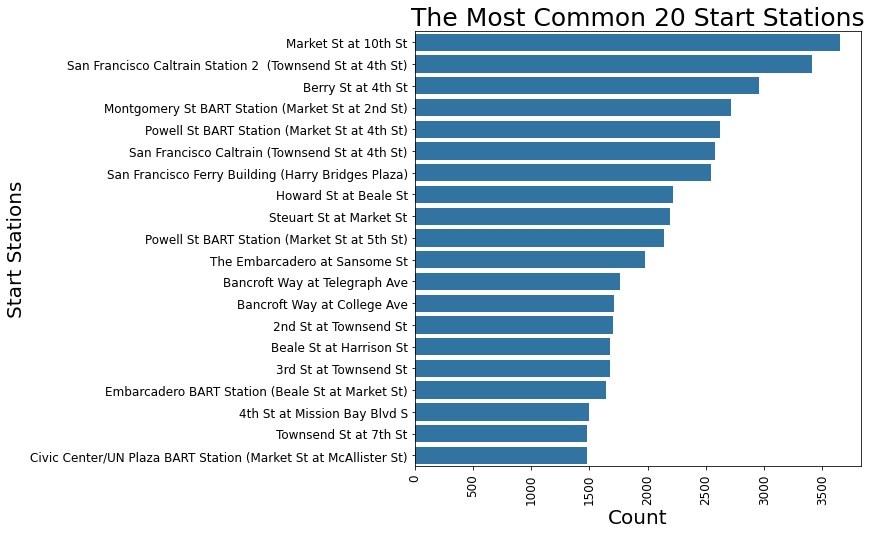

In [18]:
base_color=sb.color_palette()[0]
plt.figure(figsize=[8,8])
ax=sb.countplot(data=start_sub,y='start_station_name', color=base_color, order=start_order)
plt.xticks(rotation=90,size=12)
plt.yticks(size=12)
plt.ylabel('Start Stations',size=20)
plt.xlabel('Count',size=20)
plt.title('The Most Common 20 Start Stations',size=25);

In [19]:
end_counts = gobike['end_station_name'].value_counts().reset_index(name='number_of_trips')[:20]
end_order=end_counts['index']

In [20]:
end_sub=gobike.loc[gobike['end_station_name'].isin(end_counts["index"])]

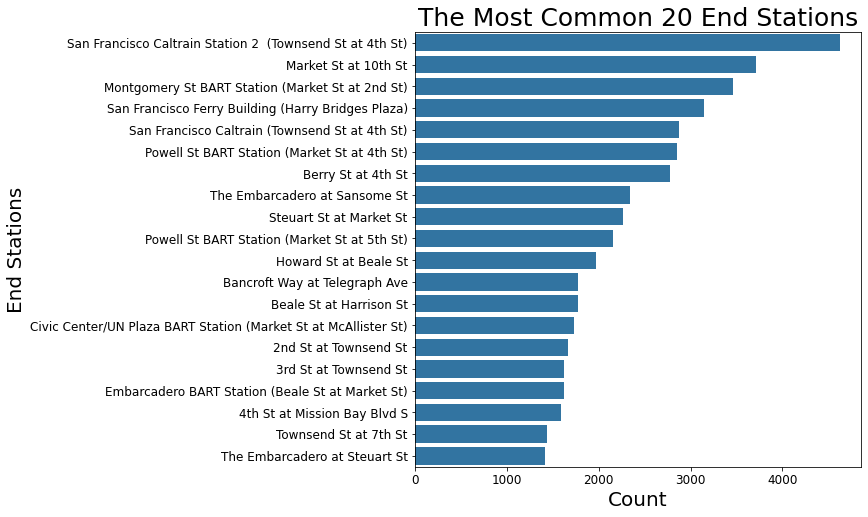

In [21]:
plt.figure(figsize=[8,8])
ax=sb.countplot(data=end_sub,y='end_station_name', color=base_color,order=end_order)
plt.ylabel('End Stations',size=20)
plt.xlabel('Count',size=20)
plt.title('The Most Common 20 End Stations',size=25)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)

In [22]:
# How many stations are in the top 20 of both the start stations and the end stations?
(end_order.isin (start_order)).sum()

19

> From the above, we notice that the most common start stations are also the most common end stations.

In [23]:
gobike.describe()

,duration_sec,age,start_hour
count,174952.000000,174952.000000,174952.000000
mean,704.002744,34.196865,13.456165
std,1642.204905,10.118731,4.734282
min,61.000000,18.000000,0.000000
25%,323.000000,27.000000,9.000000
50%,510.000000,32.000000,14.000000
75%,789.000000,39.000000,17.000000
max,84548.000000,141.000000,23.000000


> When I looked at the statistical information of the dataset to find the minimum and maximum of the trip duration, I also found that there are wrong entries in the age column making the maximum age 141 years, so I'll remove any data above 95 years old as it's highly improbable.

In [24]:
gobike=gobike.query('age < 95')

> Now, I'll look at the distribution of the trip duration.

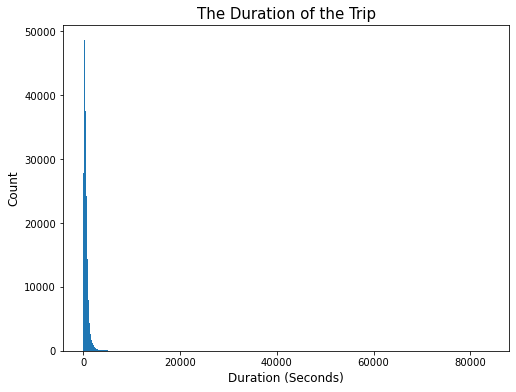

In [25]:
# The Duration with a standard scale
plt.figure(figsize=[8,6])
bins=np.arange(60,84e3,200)
plt.hist(data=gobike,x='duration_sec',bins=bins)
plt.xlabel('Duration (Seconds)', size=12)
plt.ylabel('Count', size=12)
plt.title('The Duration of the Trip', size=15);

> The curve has a very long right tail, so I'll use a logarithmic scale on the y-axis and set a limit to the x-axis to take a deeper look at the most frequent interval.

## Distribution of Trip Duration

The trip duration takes a very large range of values, from about 61 seconds at the lowest, to more than 84,000 seconds at the highest. When I used a logarithmic scale, the distribution appeared unimodal.

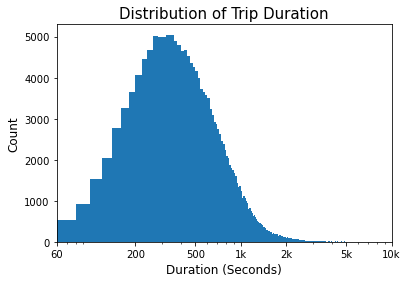

In [64]:
# The Duration with a logarithmic scale and x-axis limit
bins=np.arange(60,1e4,20)
plt.hist(data=gobike,x='duration_sec',bins=bins)
plt.xscale('log')
plt.xlim(60,1e4)
x_ticklocs=[60,200,500,1000,2000,5000,10000]
x_ticklabels=['60','200','500','1k','2k','5k','10k']
plt.xticks(x_ticklocs, x_ticklabels)
plt.xlabel('Duration (Seconds)', size=12)
plt.ylabel('Count', size=12)
plt.title('Distribution of Trip Duration', size=15);

> The curve is unimodal. It has a peak at 300 seconds, but it also has a very long right tail with most trips taking less than 1500 seconds and very few taking more than 2000 seconds.

> Now, I'll draw a Q-Q plot to determine the outliers in the duration_sec column and remove them from my dataset so that they don't skew my results and mislead me to wrong conclusions.

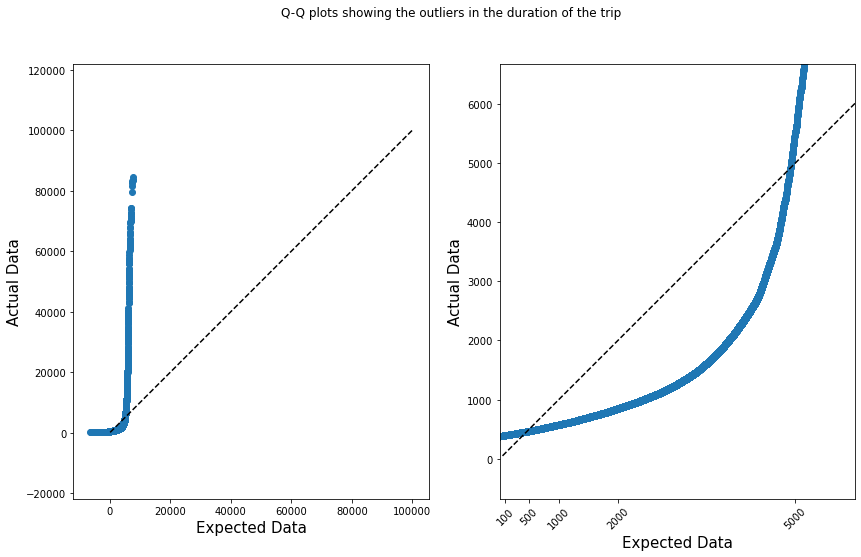

In [27]:
n_d_points = gobike.shape[0]
p_points = (np.arange(n_d_points) - 0.5) / n_d_points

sample_mean = gobike['duration_sec'].mean()
sample_std = gobike['duration_sec'].std()
expected_data = norm.ppf(p_points, sample_mean, sample_std)

plt.figure(figsize=[14,8])

plt.subplot(1,2,1)
plt.scatter(expected_data, gobike['duration_sec'].sort_values())
plt.plot([50,1e5],[50,1e5],'--', color = 'black')
plt.axis('equal')
plt.xlabel('Expected Data',size=15)
plt.ylabel('Actual Data',size=15);

plt.subplot(1,2,2)
plt.scatter(expected_data, gobike['duration_sec'].sort_values())
plt.plot([50,1e5],[50,1e5],'--', color = 'black')
plt.axis('equal')
plt.xlim(0,6000)
plt.ylim(0,6000)
plt.xticks([100,500,1000,2000,5000],[100,500,1000,2000,5000],rotation=45)
plt.xlabel('Expected Data',size=15)
plt.ylabel('Actual Data',size=15)
plt.suptitle('Q-Q plots showing the outliers in the duration of the trip');

> From the two plots above, the outliers dominate the duration column from 5k to 84k seconds, so I remove this part from my dataset.

In [28]:
gobike.shape

(174877, 10)

In [29]:
gobike=gobike.query('duration_sec <=5000')
gobike.shape

(173993, 10)

In [30]:
173993*100/174877
# I removed about 0.5 % of the dataset which represent the outliers

99.49450184987163

> Now, I'll take a look at the distribution of the predictor variables in my dataset.

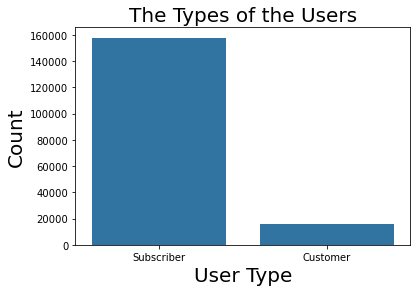

In [31]:
base_color=sb.color_palette()[0]
sb.countplot(data=gobike,x='user_type',color=base_color)
plt.xlabel('User Type',size=20)
plt.ylabel('Count',size=20)
plt.title('The Types of the Users',size=20);

> The above barplot shows that most users are subscribers, nearly about 10 times the customers.

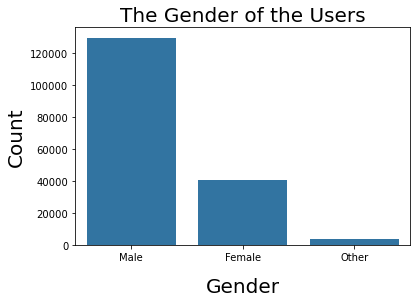

In [32]:
sb.countplot(data=gobike,x='member_gender',color=base_color)
plt.xlabel('Gender',labelpad=15,size=20)
plt.ylabel('Count',size=20)
plt.title('The Gender of the Users',size=20);

> From the above plot, we find the most users are males.

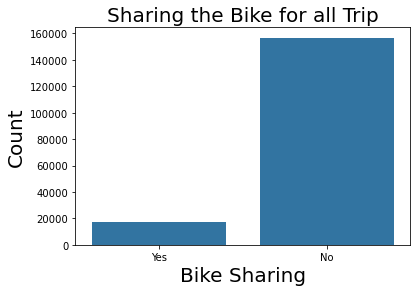

In [33]:
sb.countplot(data=gobike,x='bike_share_for_all_trip',color=base_color)
plt.xlabel('Bike Sharing',size=20)
plt.ylabel('Count',size=20)
plt.title('Sharing the Bike for all Trip',size=20);

> From the above plot, we find the most users didn't share the bike for all trip.

## Distibution of the Age of the Users
most users are 20-40 years old.

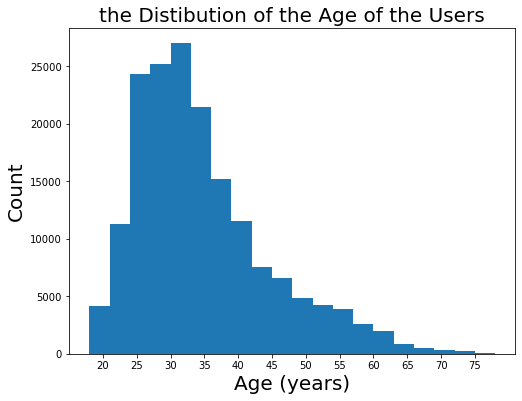

In [66]:
bins=np.arange(18,81,3)
plt.figure(figsize=[8,6])
ax=plt.hist(data=gobike,x='age',bins=bins)
plt.xticks(np.arange(20,80,5))
plt.xlabel('Age (years)',size=20)
plt.ylabel('Count', size=20)
plt.title('the Distibution of the Age of the Users',size=20);

> From the above histogram, we notice that most users are 20-40 years old.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Regarding the Duration, the curve of the duration is right skewed, so I used a logarithmic scale transformation and added an x-axis limit to focus on the most frequent interval. The curve appeared unimodal with a peak around 300 seconds.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Most users are 20-40 years old.

> Regarding the Start Hour, the curve is bimodal showing that the most common periods of the day when trips start are 7-9 am and 4-6 pm.

> Most users are subscribers, males and didn't share the bike for all trip.

> I used a Q-Q plot to remove the outliers in the duration column from the dataset. I also removed the null values, converted start and end time to datetime and removed the unrequired columns.

## Bivariate Exploration

## Duration vs. Age
the duration of the trip appears to be inversely related to the age of the user.

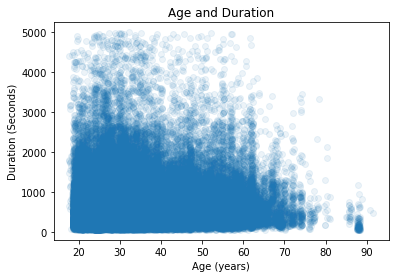

In [37]:
sb.regplot(data=gobike,x='age',y='duration_sec',fit_reg=False, x_jitter=0.4, scatter_kws={'alpha':1/12})
plt.xlabel('Age (years)')
plt.ylabel('Duration (Seconds)')
plt.title('Age and Duration');

## Duration vs. User Type
Plotting duration on a logarithmic scale, customers tend to have longer trips than subscribers.

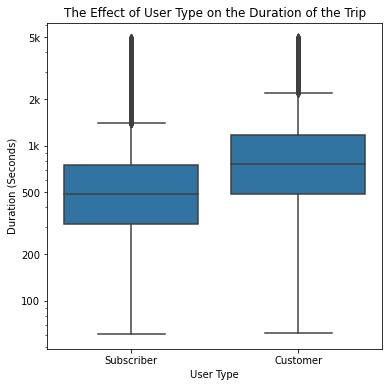

In [38]:
plt.figure(figsize=[6,6])
sb.boxplot(data=gobike,x='user_type',y='duration_sec',color=base_color)
plt.yscale('log')
y_ticklocs=[100,200,500,1e3,2e3,5e3]
y_ticklabels=['100','200','500','1k','2k','5k']
plt.yticks(y_ticklocs,y_ticklabels)
plt.xlabel('User Type')
plt.ylabel('Duration (Seconds)')
plt.title('The Effect of User Type on the Duration of the Trip');

## Duration vs. Gender
Plotting duration on a logarithmic scale, males appear to have shorter trips than other genders.

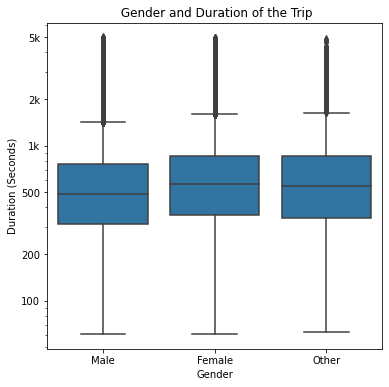

In [39]:
plt.figure(figsize=[6,6])
sb.boxplot(data=gobike,x='member_gender',y='duration_sec',color=base_color,order=['Male','Female','Other'])
plt.yscale('log')
y_ticklocs=[100,200,500,1e3,2e3,5e3]
y_ticklabels=['100','200','500','1k','2k','5k']
plt.yticks(y_ticklocs,y_ticklabels)
plt.xlabel('Gender')
plt.ylabel('Duration (Seconds)')
plt.title(' Gender and Duration of the Trip');

> The above box plot shows that males have shorter trips than other genders.

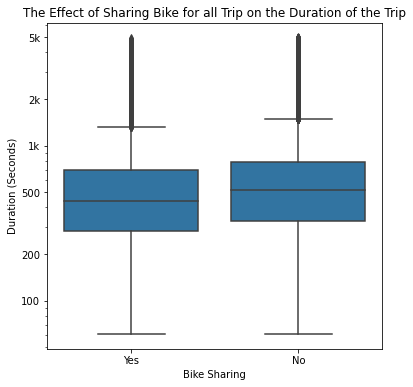

In [40]:
plt.figure(figsize=[6,6])
sb.boxplot(data=gobike,x='bike_share_for_all_trip',y='duration_sec',color=base_color)
plt.yscale('log')
y_ticklocs=[100,200,500,1e3,2e3,5e3]
y_ticklabels=['100','200','500','1k','2k','5k']
plt.yticks(y_ticklocs,y_ticklabels)
plt.xlabel('Bike Sharing')
plt.ylabel('Duration (Seconds)')
plt.title('The Effect of Sharing Bike for all Trip on the Duration of the Trip');

> The above box plot shows that sharing the bike for all trip is inversely related to the duration of the trip.

 Now, we'll look at the top 20 of both start and end stations that has the longest and shortest mean duration of the trip. 

In [41]:
start_means=gobike[['start_station_name','duration_sec']].groupby(['start_station_name']).mean()
start_ordered=start_means.sort_values(['duration_sec'], ascending=False)
longest_start=pd.DataFrame(start_ordered).reset_index().head(20)
shortest_start=pd.DataFrame(start_ordered).reset_index().tail(20)[::-1]

In [42]:
end_means=gobike[['end_station_name','duration_sec']].groupby(['end_station_name']).mean()
end_ordered=end_means.sort_values(['duration_sec'], ascending=False)
longest_end=pd.DataFrame(end_ordered).reset_index().head(20)
shortest_end=pd.DataFrame(end_ordered).reset_index().tail(20)[::-1]

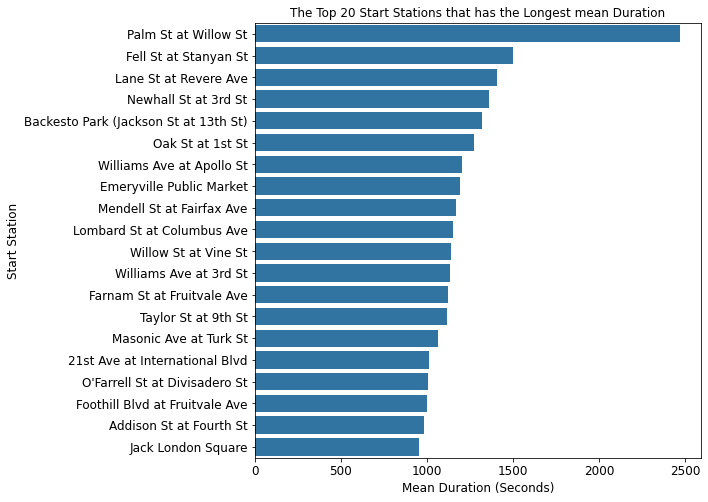

In [43]:
# The Top 20 Start Stations that has the longest mean Duration
plt.figure(figsize=[8,8])
ax=sb.barplot(data=longest_start,y='start_station_name', x='duration_sec', color=base_color)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.ylabel('Start Station',size=12)
plt.xlabel('Mean Duration (Seconds)', size=12)
plt.title('The Top 20 Start Stations that has the Longest mean Duration',size=12);

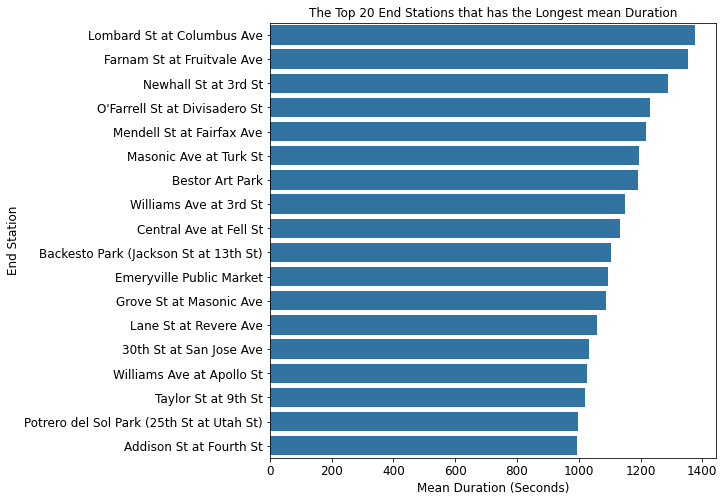

In [44]:
# The Top 20 End Stations that has the longest mean Duration
plt.figure(figsize=[8,8])
ax=sb.barplot(data=longest_end[2:],y='end_station_name', x='duration_sec', color=base_color)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.ylabel('End Station',size=12)
plt.xlabel('Mean Duration (Seconds)', size=12)
plt.title('The Top 20 End Stations that has the Longest mean Duration',size=12);

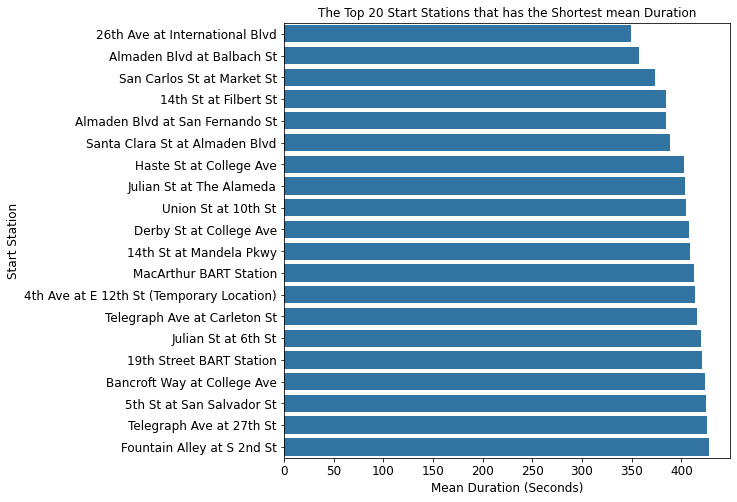

In [45]:
# The Top 20 Start Stations that has the Shortest mean Duration
plt.figure(figsize=[8,8])
ax=sb.barplot(data=shortest_start,y='start_station_name', x='duration_sec', color=base_color)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.ylabel('Start Station',size=12)
plt.xlabel('Mean Duration (Seconds)', size=12)
plt.title('The Top 20 Start Stations that has the Shortest mean Duration',size=12);

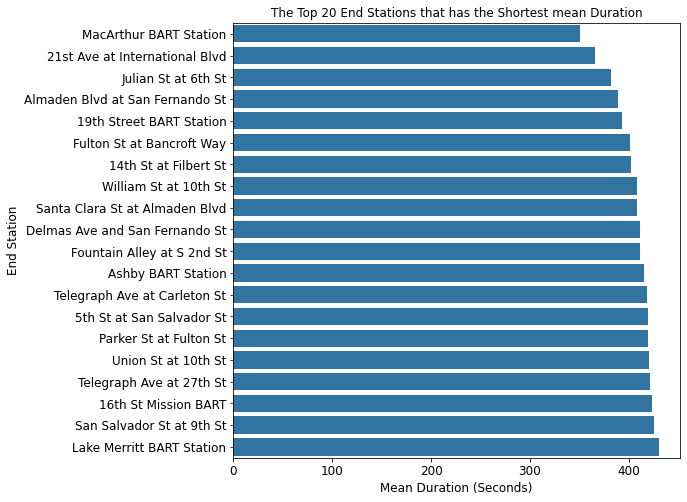

In [46]:
# The Top 20 End Stations that has the Shortest mean Duration
plt.figure(figsize=[8,8])
ax=sb.barplot(data=shortest_end,y='end_station_name', x='duration_sec', color=base_color)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(12)
plt.ylabel('End Station',size=12)
plt.xlabel('Mean Duration (Seconds)', size=12)
plt.title('The Top 20 End Stations that has the Shortest mean Duration',size=12);

In [47]:
# How many Stations are associated with the longest duration as both Start and End Station
longest_start['start_station_name'].isin(longest_end['end_station_name']).sum()

14

In [48]:
# How many Stations are associated with the Shortest duration as both Start and End Station
shortest_start['start_station_name'].isin(shortest_end['end_station_name']).sum()

11

> From the above 4 plots, we find the most stations that are associated with the longest duration as a start station are also associated with the longest duration as an end station and the same is true for the stations associated with the shortest duration.

#### Now, I'll look at the relationship between the age and 2 variables ( User Type and  Bike Sharing).

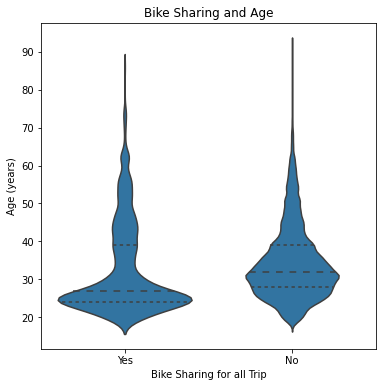

In [49]:
plt.figure(figsize=[6,6])
sb.violinplot(data=gobike,x='bike_share_for_all_trip',y='age',color=base_color,inner='quartile')
plt.xlabel('Bike Sharing for all Trip')
plt.ylabel ('Age (years)');
plt.title('Bike Sharing and Age');

> The above violin plot shows that sharing the bike is more likely to occur with young users in the twenties of age.

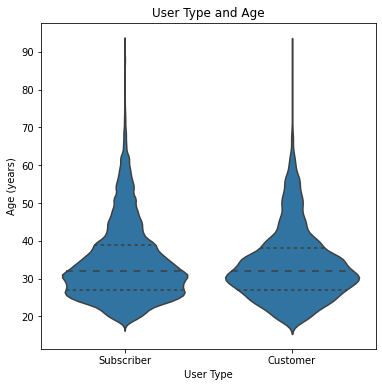

In [50]:
plt.figure(figsize=[6,6])
sb.violinplot(data=gobike,x='user_type',y='age',color=base_color,inner='quartile')
plt.xlabel('User Type')
plt.ylabel ('Age (years)');
plt.title('User Type and Age');

> The above violinplot failed to show that the user type is related to the age.

#### Other Investigations:

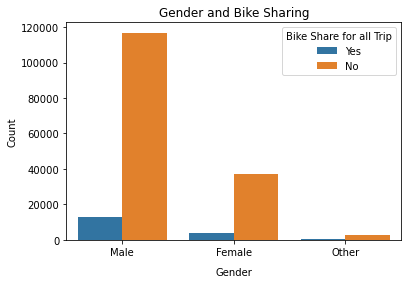

In [51]:
sb.countplot(data=gobike,x='member_gender',hue='bike_share_for_all_trip')
plt.xlabel('Gender',labelpad=10)
plt.ylabel('Count')
plt.legend(title='Bike Share for all Trip')
plt.title('Gender and Bike Sharing');

> There's no apparent relationship between gender and sharing the bike.

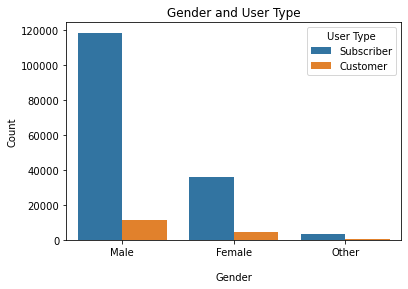

In [52]:
sb.countplot(data=gobike,x='member_gender',hue='user_type')
plt.xlabel('Gender',labelpad=15)
plt.ylabel('Count')
plt.legend(title='User Type')
plt.title('Gender and User Type');

> There's no apparent relationship between Gender and User Type.

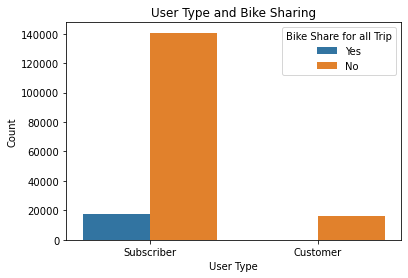

In [53]:
sb.countplot(data=gobike,x='user_type',hue='bike_share_for_all_trip')
plt.xlabel('User Type')
plt.ylabel('Count')
plt.legend(title='Bike Share for all Trip')
plt.title('User Type and Bike Sharing');

> Bike sharing occurs only by subscribers which is intuitive.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> The duration of the trip is inversely related to the age. The younger the user, the longer the trip.

> Subscribers tend to have longer trips than customers.

> Males tend to have shorter trips than females.

> Users who share the bike for all trip have shorter trips than those who don't.


> Most of the start stations that are associated with the longest trips are also associated with the longest trips as end stations.

>  Most of the start stations that are associated with the shortest trips are also associated with the shortest trips as end stations

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Most users who share bikes are in the twenties of age.

> Bike sharing occurs only by subscribers which is intuitive.

## No features appear to strengthen or weaken the relationship between the duration of the trip and the age of the user.

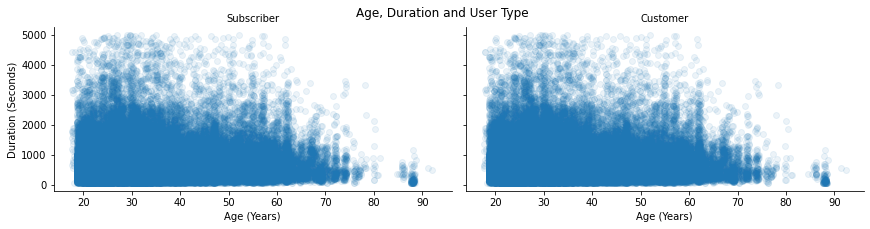

In [54]:
g=sb.FacetGrid(data=gobike,col='user_type',height=3,aspect=2)
g.map(sb.regplot,data=gobike, x='age',y='duration_sec',fit_reg=False, x_jitter=0.4, scatter_kws={'alpha':1/12})
g.set_titles('{col_name}')
g.set_axis_labels('Age (Years)','Duration (Seconds)')
plt.suptitle('Age, Duration and User Type');

> The User Type has no effect on the relationship between the Age and the Duration.

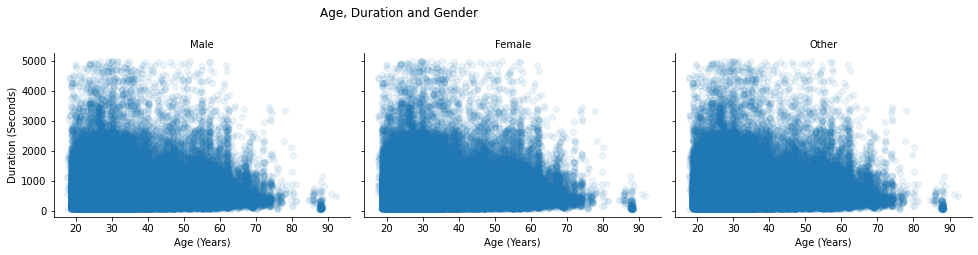

In [55]:
g=sb.FacetGrid(data=gobike,col='member_gender',height=3,aspect=1.5)
g.map(sb.regplot,data=gobike, x='age',y='duration_sec',fit_reg=False, x_jitter=0.4, scatter_kws={'alpha':1/12})
g.set_titles('{col_name}')
g.set_axis_labels('Age (Years)','Duration (Seconds)')
plt.suptitle('Age, Duration and Gender',x=0.4,y=1.1);

> The Gender has no effect on the relationship between the Age and the Duration.

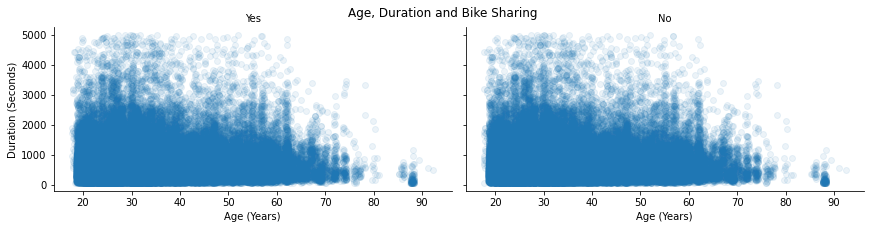

In [56]:
g=sb.FacetGrid(data=gobike,col='bike_share_for_all_trip',height=3,aspect=2)
g.map(sb.regplot,data=gobike, x='age',y='duration_sec',fit_reg=False, x_jitter=0.4, scatter_kws={'alpha':1/12})
g.set_titles('{col_name}')
g.set_axis_labels('Age (Years)','Duration (Seconds)')
plt.suptitle('Age, Duration and Bike Sharing');

> Bike Sharing has no effect on the relationship between the Age and the Duration.

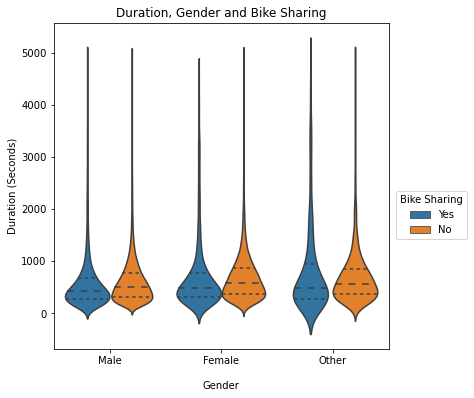

In [57]:
plt.figure(figsize=[6,6])
sb.violinplot(data=gobike,x='member_gender',y='duration_sec',hue='bike_share_for_all_trip',inner='quartile')
plt.xlabel('Gender', labelpad=15)
plt.ylabel('Duration (Seconds)')
plt.title('Duration, Gender and Bike Sharing')
plt.legend(title='Bike Sharing', bbox_to_anchor=(1.25,0.5));

> Bike Sharing increases the trip duration in all genders.

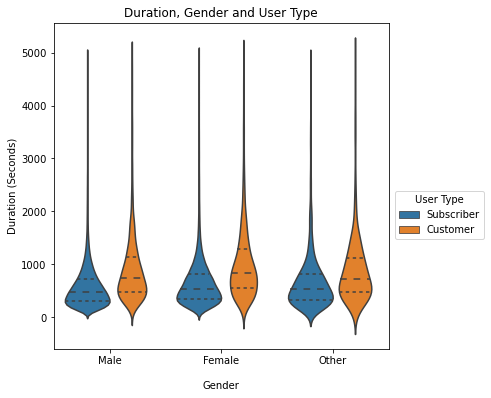

In [58]:
plt.figure(figsize=[6,6])
sb.violinplot(data=gobike,x='member_gender',y='duration_sec',hue='user_type',inner='quartile')
plt.xlabel('Gender', labelpad=15)
plt.ylabel('Duration (Seconds)')
plt.title('Duration, Gender and User Type')
plt.legend(title='User Type', bbox_to_anchor=(1.3,0.5));

> Subscribers have shorter trips in all genders.

> I'll create a new column (start_end) that has in each cell the start and end stations of the trip to look at the start and end stations of both the longest and the shortest trips.

In [59]:
gobike['start_end']=gobike['start_station_name'] + ' to '+ gobike['end_station_name']
trip_means=gobike[['start_end','duration_sec']].groupby(['start_end']).mean()
trip_ordered= trip_means.sort_values(['duration_sec'], ascending=False)
longest_trip=pd.DataFrame(trip_ordered).reset_index().head(20)
shortest_trip=pd.DataFrame(trip_ordered).reset_index().tail(20)[::-1]

## The Longest 20 Trips from the Start Station to the End Station

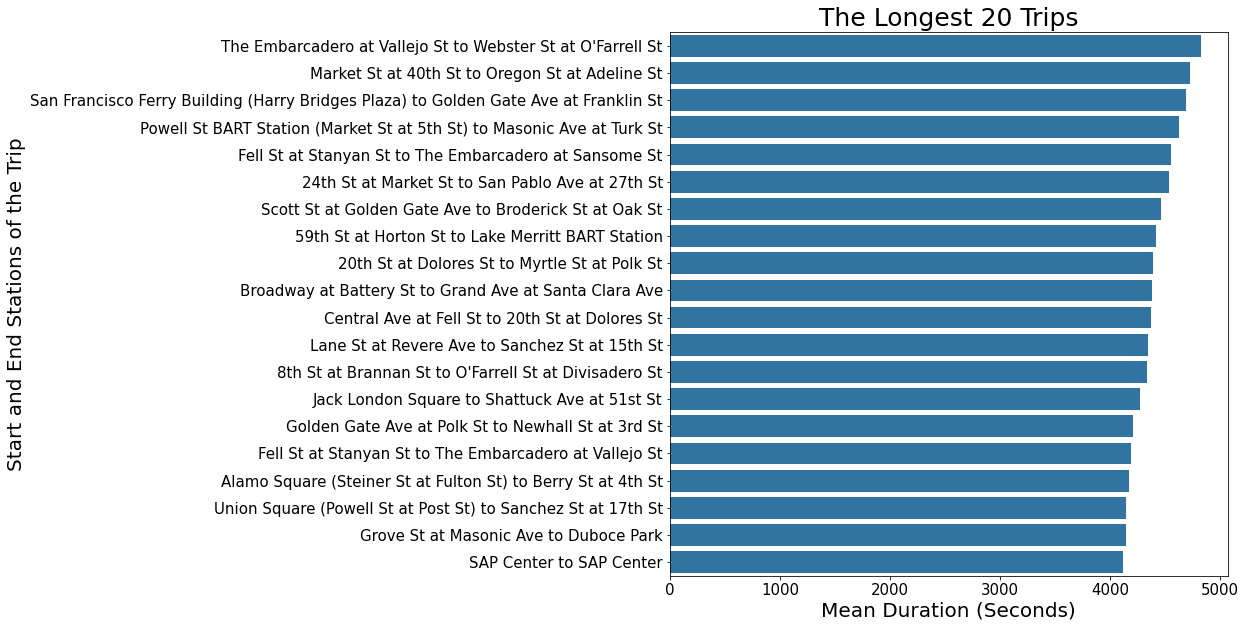

In [69]:
plt.figure(figsize=[10,10])
ax=sb.barplot(data=longest_trip, x='duration_sec', y='start_end',color=base_color)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.xlabel('Mean Duration (Seconds)',size=20)
plt.ylabel('Start and End Stations of the Trip',size=20)
plt.title('The Longest 20 Trips',size=25);

## The Shortest 20 Trips from the Start Station to the End Station

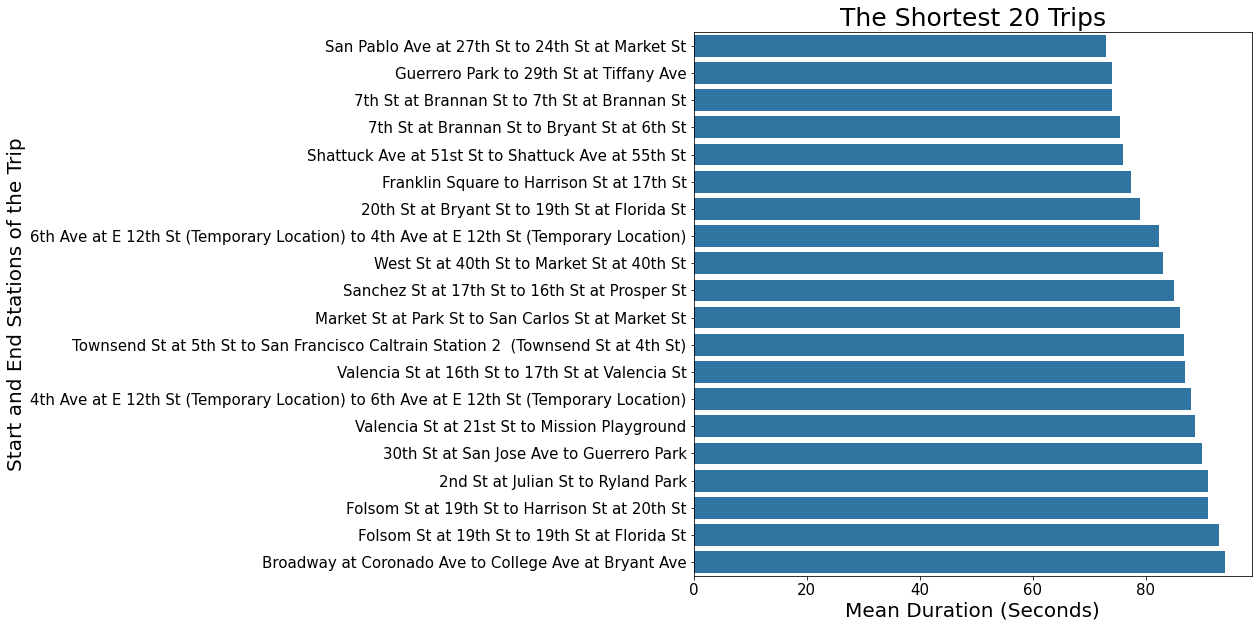

In [70]:
plt.figure(figsize=[10,10])
ax=sb.barplot(data=shortest_trip, x='duration_sec', y='start_end',color=base_color)
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(15)
plt.xlabel('Mean Duration (Seconds)',size=20)
plt.ylabel('Start and End Stations of the Trip',size=20)
plt.title('The Shortest 20 Trips',size=25);

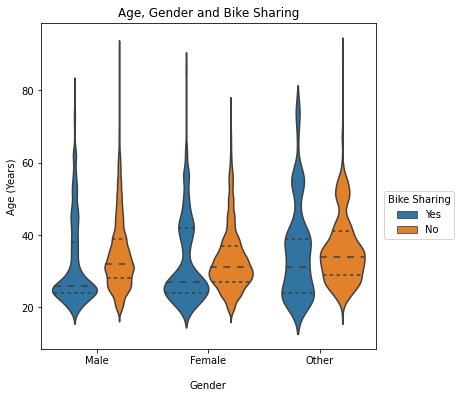

In [62]:
plt.figure(figsize=[6,6])
sb.violinplot(data=gobike,x='member_gender',y='age',hue='bike_share_for_all_trip',inner='quartile')
plt.xlabel('Gender', labelpad=15)
plt.ylabel('Age (Years)')
plt.title('Age, Gender and Bike Sharing')
plt.legend(title='Bike Sharing', bbox_to_anchor=(1.25,0.5));

> Bike Sharing is associated with younger age in all genders.

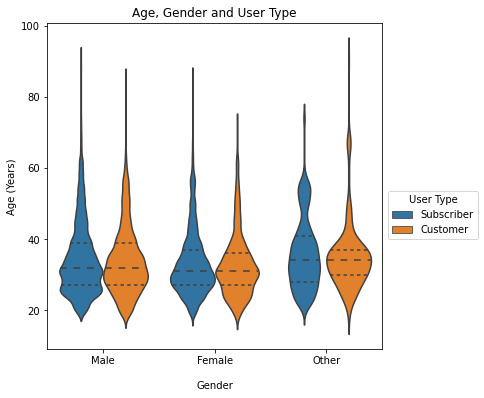

In [63]:
plt.figure(figsize=[6,6])
sb.violinplot(data=gobike,x='member_gender',y='age',hue='user_type',inner='quartile')
plt.xlabel('Gender', labelpad=15)
plt.ylabel('Age (Years)')
plt.title('Age, Gender and User Type')
plt.legend(title='User Type', bbox_to_anchor=(1.3,0.5));

> User type isn't related to neither the Age nor the Gender of the user.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> I failed to find any interactions in the multivariate analysis.

### Were there any interesting or surprising interactions between features?

> Unfortunately, no.

## Distribution of the Start Hour of the Trip
The most common periods of the day when trips start are 7-9 am and 4-6 pm.

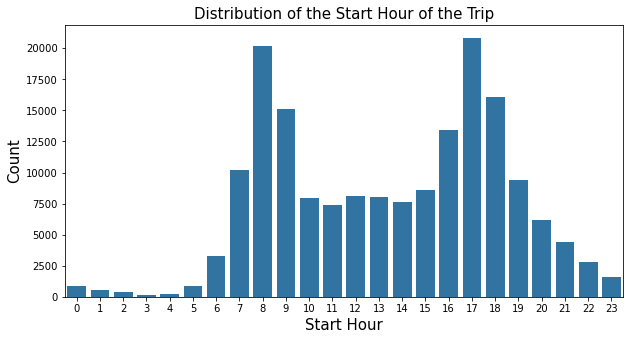

In [72]:
plt.figure(figsize=[10,5])
sb.countplot(data=gobike, x='start_hour',color=base_color)
plt.xlabel('Start Hour',size=15)
plt.ylabel('Count',size=15)
plt.title('Distribution of the Start Hour of the Trip',size=15);

> The above barplot is bimodal with 2 peaks at 8 am and 5 pm showing that the most common periods of the day when trips start are 7-9 am and 4-6 pm.